<a href="https://colab.research.google.com/github/ugurtegin/Nonlinear_MMF_Network/blob/main/Simulations/BPM_sinc_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries


In [ ]:
from google.colab import drive

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


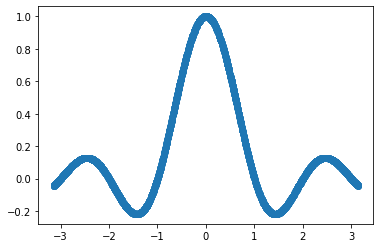

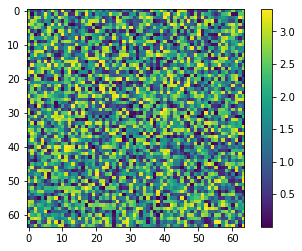

In [ ]:
# Create random phase input

rand_sample=cp.random.rand(3000)

rescaled=rand_sample*2*cp.pi-cp.pi
sio.savemat('/content/drive/MyDrive/BPM_sinc_paper/rescaled_input.mat',{'rescaled_intput':rescaled.get()})

sinc_out=cp.sinc(rescaled)
sio.savemat('/content/drive/MyDrive/BPM_sinc_paper/sinc_out.mat',{'sinc_out':sinc_out.get()})

plt.scatter(rescaled.get(),sinc_out.get())
plt.show()

mask=cp.random.rand(64,64)


masked_input=cp.zeros((3000,64,64))
for ii in range(3000):

  masked_input[ii]=rand_sample[ii]*mask


masked_input=masked_input*cp.pi*2


sio.savemat('/content/drive/MyDrive/BPM_sinc_paper/masked_input.mat',{'masked_input':masked_input.get()})

plt.imshow(masked_input[355].get())
plt.colorbar()


# Super Gaussian for boundary

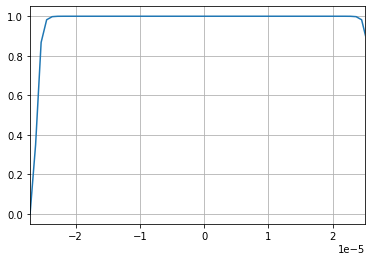

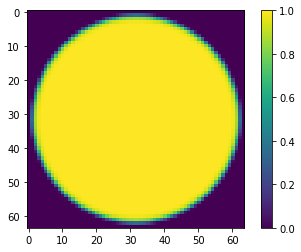

In [ ]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1,p=60,w=26.5e-6):
  """define normalized 2D gaussian"""

  return np.exp(-2*((np.sqrt(x**2+y**2)/w)**p))

spacewidth=54.1442e-6

xres=54.1442e-6/64
x = np.linspace(-spacewidth*0.5,spacewidth*0.5,int(spacewidth/xres))

x1, y1 = np.meshgrid(x, x) # get 2D variables instead of 1D
z = gaus2d(x1, y1)

# plt.imshow(z)
# plt.colorbar()

plt.plot(x,z[32,:])
plt.grid()
plt.xlim((-27.0721e-6,25e-6))
plt.show()

cp_super_gauss2d =cp.asarray(z)
cp_super_gauss2d = cp.repeat(cp_super_gauss2d[:,:,cp.newaxis], 2048, axis=2)

plt.imshow(z)
plt.colorbar()
plt.show()



# BPM 


In [ ]:
tt = time.time()
c = 299792458 # [m/s]
n0 = 1.44                   # Refractive index of medium
lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]
#k0 = 2*pi/lambda_c         # [1/m]
#k = k0*n0                  # [1/m]

## TIME SPACE DOMAIN
timewidth = 20e-12          # Width of the time window in [s]
tres = timewidth/((2**11))
t = cp.arange(-timewidth*0.5,(timewidth*0.5),tres)
#t = -timewidth*0.5:tres:timewidth*0.5 # Time in [s]
timesteps=len(t)

spacewidth=54.1442e-6
xres = spacewidth/((2**6))
#x = -spacewidth*0.5:xres:spacewidth*0.5 # Time in [s]
x = cp.arange(-spacewidth*0.5,(spacewidth*0.5),xres)
xsteps=len(x)
y = x
[X,Y,T] = cp.meshgrid(x,y,t)

## FOURIER DOMAIN
fs=1/timewidth
freq = c/lambda_c+fs*cp.linspace(-timesteps/2,timesteps/2,num = timesteps)
#freq=c/lambda_c+fs*linspace(-(timesteps-1)/2,(timesteps-1)/2,timesteps) # [Hz]
wave=c/freq # [m]
w=2*cp.pi*c/lambda_c # [Hz]
omegas=2*cp.pi*freq
wt = omegas-w

#kx = 2*pi/xsteps/xres*x;
#kx = 2*pi/xres*x;

#CHECK KX
a = cp.pi/xres  # grid points in "frequency" domain--> {2*pi*(points/mm)}
N = len(x)
zbam = cp.arange(-a,(a-2*a/N)+(2*a/N),2*a/N)
kx = cp.transpose(zbam) # "frequency" domain indexing ky = kx; 
ky = kx
[KX,KY,WT] = cp.meshgrid(kx,ky,wt);
## OPERATORS
k0 = w*n0/c
n2 = 3.2e-20       #Kerr coefficient (m^2/W)
R = 25e-6
beta2 = 24.8e-27
beta3 = 23.3e-42
gamma = (2*cp.pi*n2/(lambda_c))
delta = 0.01
NL1 = -1j*((k0*delta)/(R*R))*((X**2)+(Y**2))

D1 = (0.5*1j/k0)*((-1j*(KX))**2+(-1j*(KY))**2)
D2 = ((-0.5*1j*beta2)*(-1j*(WT))**2)+((beta3/6)*(-1j*(WT))**3)
D = D1 + D2
dz = 555e-6/16
DFR = cp.exp(D*dz/2)

## INPUT 
flength = 555e-6*10
fstep = flength/dz
x_fwhm = 25e-6
t_fwhm = 1e-12
Ppeak = 10e6 # kW



for musti in range(3000):
  slm = masked_input[musti]
  slm = cp.exp(1j*slm)
  slm2 = cp.repeat(slm[:,:,cp.newaxis], 2048, axis=2)
  A = slm2*cp.sqrt(Ppeak/(cp.pi*x_fwhm*x_fwhm))*cp.exp( - ((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2) + (T**2)/(2*(t_fwhm/2.35482)**2)));
  ### MAIN FUNCTION
  Ain = A
  #Asave = cp.zeros((sampesize,64,64,1024), dtype=complex)


  for ugur in range(int(fstep)):
      #print((ugur*dz)+dz)
      Einf=cp.fft.fftshift(cp.fft.fftn(Ain));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      Eout = Ein2;
      
      NL2 = 1j*gamma*cp.abs(Eout)**2;
      NL = NL1+NL2;
      Eout = Eout*cp.exp(NL*dz);
      
      Einf=cp.fft.fftshift(cp.fft.fftn(Eout));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      #Ain = Ein2;
      Ain =cp.multiply(cp_super_gauss2d,Ein2);
  
  Ain_cpu=Ain.get()  
  sio.savemat('/content/drive/MyDrive/BPM_sinc_paper/sinc_data/data'+str(musti)+'.mat', {'Ain':Ain_cpu})
  


elapsed = time.time() - tt
print(elapsed)

8474.957721948624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


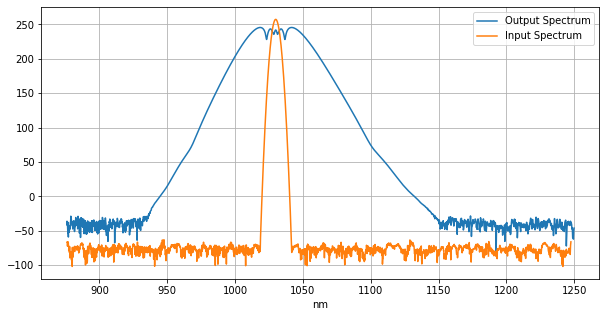

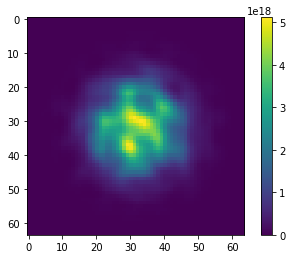

In [ ]:
www=wave.get()
s =np.squeeze(np.sum(np.squeeze(np.sum(Ain_cpu,axis=0)),axis=0))
s_in =np.squeeze(np.sum(np.squeeze(np.sum(A.get(),axis=0)),axis=0))
sf=np.fft.fftshift(np.fft.fft(s))
sf_in=np.fft.fftshift(np.fft.fft(s_in))
fig=plt.figure(figsize=(10,5))
plt.plot(www*1e9,10*np.log10(np.abs(sf)**2),label='Output Spectrum')
plt.plot(www*1e9,10*np.log10(np.abs(sf_in)**2),label='Input Spectrum')
plt.legend()
plt.grid()
plt.xlabel('nm')
plt.show()

ampltd =np.sum(Ain_cpu,axis=2)
plt.imshow((np.abs(ampltd)**2))
plt.colorbar()
plt.show()

# Processing

In [ ]:
# Load and create normalized intensity images

tot=np.zeros((3000,64,64))
for ugur in range(3000):
  f = sio.loadmat('/content/drive/MyDrive/BPM_sinc_paper/sinc_data/data'+str(ugur)+'.mat')
  Ain = f['Ain']

  sq=np.abs(np.squeeze(np.sum(Ain,axis=2)))**2

  tot[ugur]=sq/np.max(sq)


sio.savemat('/content/drive/MyDrive/BPM_sinc_paper/tot.mat',{'tot':tot})

In [ ]:

f = sio.loadmat('/content/drive/MyDrive/BPM_sinc_paper/sinc_out.mat')
y= f['sinc_out']

In [ ]:
# Flatten images
flattened=np.zeros((3000,20*20))


from skimage.transform import resize
for ii in range(3000):
  qq=np.copy(tot[ii])

  #small=qq.reshape([nsmall, nbig//nsmall, nsmall, nbig//nsmall]).mean(3).mean(1)
  small=resize(qq, (20, 20))
  flattened[ii]=np.reshape(small,(20*20,))

In [ ]:
X=flattened
y=sinc_out.get()
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X[:2400,:], y[:2400])
reg.score(X[2400:,:], y[2400:])

pred=reg.predict(X)
sio.savemat('/content/drive/MyDrive/Optical DNN Project/1. MMF_Network_Paper/BPM_sinc_paper/pred_y_x.mat',{'pred':pred,'y':y,'x':rescaled.get()})

0.9998767741995019